In [ ]:
cd /content/drive/MyDrive/기계학습 과제/팀플

/content/drive/MyDrive/기계학습 과제/팀플


In [ ]:
# basic imports
import numpy as np
import pandas as pd
import os

In [ ]:
# initialising the train dataset into a dataframe
traindataset = pd.read_csv("./train.csv")
train = traindataset[:5000]

In [ ]:
# initialising the test dataset into a dataframe
testdataset = pd.read_csv("./test.csv")
test = testdataset[:5000]

In [ ]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
# pre-processing #
train.drop(["id", "keyword", "location"], axis = 1)
test.drop(["id", "keyword", "location"], axis = 1)

,text
0,powerful winter storms moving across the
1,country parts of the Northeast bracing
2,for its first snowfall of the season in
3,just a matter of hours in the Westmead
4,time the mountains of California getting
...,...
590,there are fears that they're wasting
591,away
592,and for many hopes of a brighter future
593,at home are fading


In [ ]:
# download stopwords and punkt from nltk
import nltk

nltk.download("stopwords")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# performing basic pre-processing on the Corpus
import re
import string
stopwords = nltk.corpus.stopwords.words('english')
stemmer = nltk.PorterStemmer()

def count_punct(text):
  count = sum([1 for char in text if char in string.punctuation])
  return round(count/(len(text) - text.count(" ")), 3)*100

traindataset['body_len'] = traindataset['text'].apply(lambda x: len(x) - x.count(" "))
traindataset['punct%'] = traindataset['text'].apply(lambda x: count_punct(x))

def clean_text(text):
  text = "".join([word.lower() for word in text if word not in string.punctuation])
  tokens = re.split('\W+', text)
  text = [stemmer.stem(word) for word in tokens if word not in stopwords]
  return text

In [ ]:
# creating Train, Test and Split Datasets
from sklearn.model_selection import train_test_split

X = traindataset[['text', 'body_len', 'punct%']]
y = traindataset['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [ ]:
# vectorising the Corpus using TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(analyzer=clean_text)
tfidf_vect_fit = tfidf_vect.fit(X_train['text'])

tfidf_train = tfidf_vect_fit.transform(X_train['text'])
tfidf_test = tfidf_vect_fit.transform(X_test['text'])

X_train_vect = pd.concat([X_train[['body_len', 'punct%']].reset_index(drop=True),
                          pd.DataFrame(tfidf_train.toarray())], axis=1)
X_test_vect = pd.concat([X_test[['body_len', 'punct%']].reset_index(drop=True),
                         pd.DataFrame(tfidf_test.toarray())], axis=1)

X_train_vect.head()

,body_len,punct%,0,1,2,3,4,5,6,7,...,13411,13412,13413,13414,13415,13416,13417,13418,13419,13420
0,92,7.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,116,6.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,53,1.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,81,6.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,82,8.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# importing necessary packages from sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score as acs
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# training the model #
rf = RandomForestClassifier(n_estimators=150, max_depth=None, n_jobs=-1)

rf_model = rf.fit(X_train_vect, y_train)

importances = rf_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
  print("{}. feature {} ({:.3f})".format(f + 1, X_train_vect.columns[indices][f], importances[indices[f]]))

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Feature ranking:
1. feature body_len (0.023)
2. feature punct% (0.019)
3. feature 3652 (0.010)


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Precision: 0.838 / Recall: 0.629 / F1-Score: 0.719 / Accuracy: 0.79


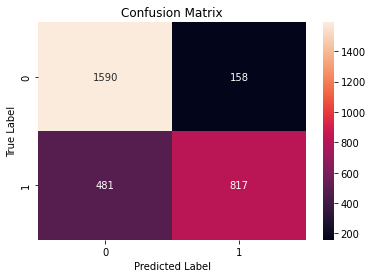

In [ ]:
y_pred = rf_model.predict(X_test_vect)

precision, recall, fscore, train_support = score(y_test, y_pred, pos_label=1, average='binary')
print('Precision: {} / Recall: {} / F1-Score: {} / Accuracy: {}'.format(round(precision, 3), round(recall, 3), round(fscore, 3), round(acs(y_test, y_pred), 3)))

# making the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
class_label = [0, 1]
df_cm = pd.DataFrame(cm, index=class_label, columns=class_label)
sns.heatmap(df_cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

n_estimators = 1000
- Precision: 0.842 / Recall: 0.66 / F1-Score: 0.74 / Accuracy: 0.804

In [ ]:
testdataset['body_len'] = testdataset['text'].apply(lambda x: len(x) - x.count(" "))
testdataset['punct%'] = testdataset['text'].apply(lambda x: count_punct(x))
tfidf_test = tfidf_vect_fit.transform(testdataset['text'])
test_vect = pd.concat([testdataset[['body_len', 'punct%']].reset_index(drop=True),
                         pd.DataFrame(tfidf_test.toarray())], axis=1)
test_pred = rf_model.predict(test_vect)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [ ]:
import random

index = random.sample(range(0, 595), 10)
for i in index:
  print(testdataset['text'][i], test_pred[i])

efforts in Search and evacuation of the 0
part of the country about nine inches of 0
correspondent valdia baraputri reports 0
packed with local tourists derailed in a 1
the world is just getting battered More 0
children are trapped here i go to school 0
astonishing amounts of rain have fallen 0
in people smuggled out 0
bringing very destructive wins 150 mile 0
problem causing a lot of local flooding 1
